Notebook to prepare the intermediate 201702 bathymetry. Susan's notebook loads the result of this notebook, and does additional processing to produce the final version of the bathymetry.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import os,cmocean
import scipy.io as sio
from bathy_helpers import *
from bathy_readers import *
from bathy_prepare import *
from bathy_showers import *
from salishsea_tools import bathy_tools

In [2]:
# Load bathy, and the t and f grid
bathyd1 = getnemo('/home/mdunphy/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc',     fillmissing=True)
bathy6  = getnemo('/home/mdunphy/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea6.nc', fillmissing=True)

# Original SalishSea grid
with nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/coordinates_seagrid_SalishSea.nc', 'r') as cnc:
    glamf0 = cnc.variables['glamf'][0,...]; gphif0 = cnc.variables['gphif'][0,...]
    glamt0 = cnc.variables['glamt'][0,...]; gphit0 = cnc.variables['gphit'][0,...]

# Compressed Fraser region grid
with nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/coordinates_seagrid_SalishSea201702.nc', 'r') as cnc:
    glamf = cnc.variables['glamf'][0,...]; gphif = cnc.variables['gphif'][0,...]
    glamt = cnc.variables['glamt'][0,...]; gphit = cnc.variables['gphit'][0,...]
NY, NX = glamt.shape[0], glamt.shape[1]
glamfe, gphife = expandf(glamf, gphif)

# Coastline files
mfile = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
ncst = mfile['ncst']
mfile = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat')
ncstr = mfile['ncst']

In [3]:
# Next we load each re-gridded bathy product (they are cached so this is quick)

In [4]:
cascadiafile = '/home/mdunphy/MEOPAR/WORK/Bathy-201702/Cascadia/cascadia.bil'
cache=prepare_cascadia(cascadiafile,glamt,gphit,glamf,gphif,glamfe,gphife)
locals().update(np.load(cache))

In [5]:
chsfile = '/home/mdunphy/MEOPAR/WORK/Bathy-201702/CHS/Salish Sea 25m Grid.txt'
cache=prepare_chs(chsfile,glamt,gphit,glamf,gphif,glamfe,gphife)
locals().update(np.load(cache))

In [6]:
chs2path='/home/mdunphy/MEOPAR/WORK/Bathy-201702/Data_From_Mitchell_CHS/'
cache=prepare_chs2(chs2path,glamt,gphit,glamf,gphif,glamfe,gphife)
locals().update(np.load(cache))

In [7]:
bc3file = '/home/mdunphy/MEOPAR/WORK/Bathy-201702/BC3/british_columbia_3sec.asc'
cache=prepare_bc3(bc3file,glamt,gphit,glamf,gphif,glamfe,gphife)
locals().update(np.load(cache))

In [8]:
cache = "/home/mdunphy/MEOPAR/WORK/Bathy-201702/mdbathy_feb14.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Synthesize a new bathy by a weighted sum (Cascadia, BC3 and new CHS)
    md0 = bathyblend(casmean, bc3mean, chs2mean, 1, 5, 10)

    # Clip depth of water points to [4,428]
    md1 = np.copy(md0)
    md1[(md1 > 0) & (md1 < 4)] = 4
    md1[md1 > 428] = 428

   
    # Truncate Vancouver Harbour
    zeroA = [(338,450),(339,450),(343,456),(344,456),(344,457),(344,458)]

    # Truncate Fraser river at south
    i0,i1 = 378, 396
    j0=413
    zeroB = [(i,j0) for i in range(i0,i1)]

    # Truncate Fraser river north extension at west
    i0=395
    j0,j1=414,500
    zeroC = [(i0,j) for j in range(j0,j1)]

    # Truncate Fraser river north extension at east
    i0=393
    j0,j1=416,500
    zeroD = [(i0,j) for j in range(j0,j1)]

    # Set those points to zero depth (the lake filler will remove the excised parts)
    for i,j in zeroA+zeroB+zeroC+zeroD:
        md1[j,i]=0

    # Extend fraser river north
    i0 = 394
    j0,j1 = 414,500
    for j in range(j0,j1+1):
        md1[j,i0]=10           # 10m depth for now
    
    # Fill in lakes
    mdL = lakefill( md1 )

    np.savez(cache, md0=md0, md1=md1, mdL=mdL)

In [9]:
# Look at some slices through the bathy
def slp(bathys,names,j,i1,i2):
    for b in bathys:
        plt.plot(glamt[j,i1:i2],-b[j,i1:i2])
    plt.legend(names,loc=0)
    plt.grid(True)

<IPython.core.display.Javascript object>


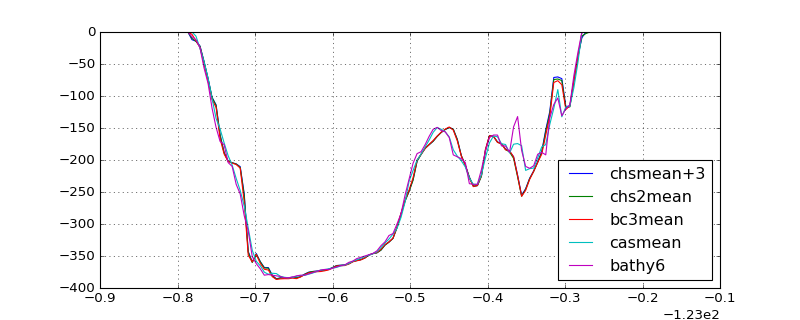

In [10]:
plt.figure(figsize=(10,4)); plt.clf();
chsmeano = np.copy(chsmean); chsmeano[chsmeano!=0]+=3
slp([chsmeano,chs2mean,bc3mean,casmean,bathy6],['chsmean+3','chs2mean','bc3mean','casmean','bathy6'],475,220,350)
#slp([chsmeano,chs2mean],['chsmeano','chs2mean'],475,220,350)
#slp([chsmax,chs2max,bc3max,casmax],['chsmax','chs2max','bc3max','casmax'],450,220,300)
#slp([chsmedian,chs2median,bc3median,casmedian],['chsmedian','chs2median','bc3median','casmedian'],450,220,300)

In [11]:
def shrz(xf,yf,xt,yt,bathy,cb,ttl):
    shwll(xf,yf,bathy,None,cb,ttl)
    plt.plot(ncst[:,0],ncst[:,1],'r',linewidth=0.5)
    plt.plot(ncstr[:,0],ncstr[:,1],'r',linewidth=0.5)
    #pw=np.where(bathy>0)
    #plt.plot(xt[pw[0],pw[1]], yt[pw[0],pw[1]], 'b.', markersize=3)

<IPython.core.display.Javascript object>


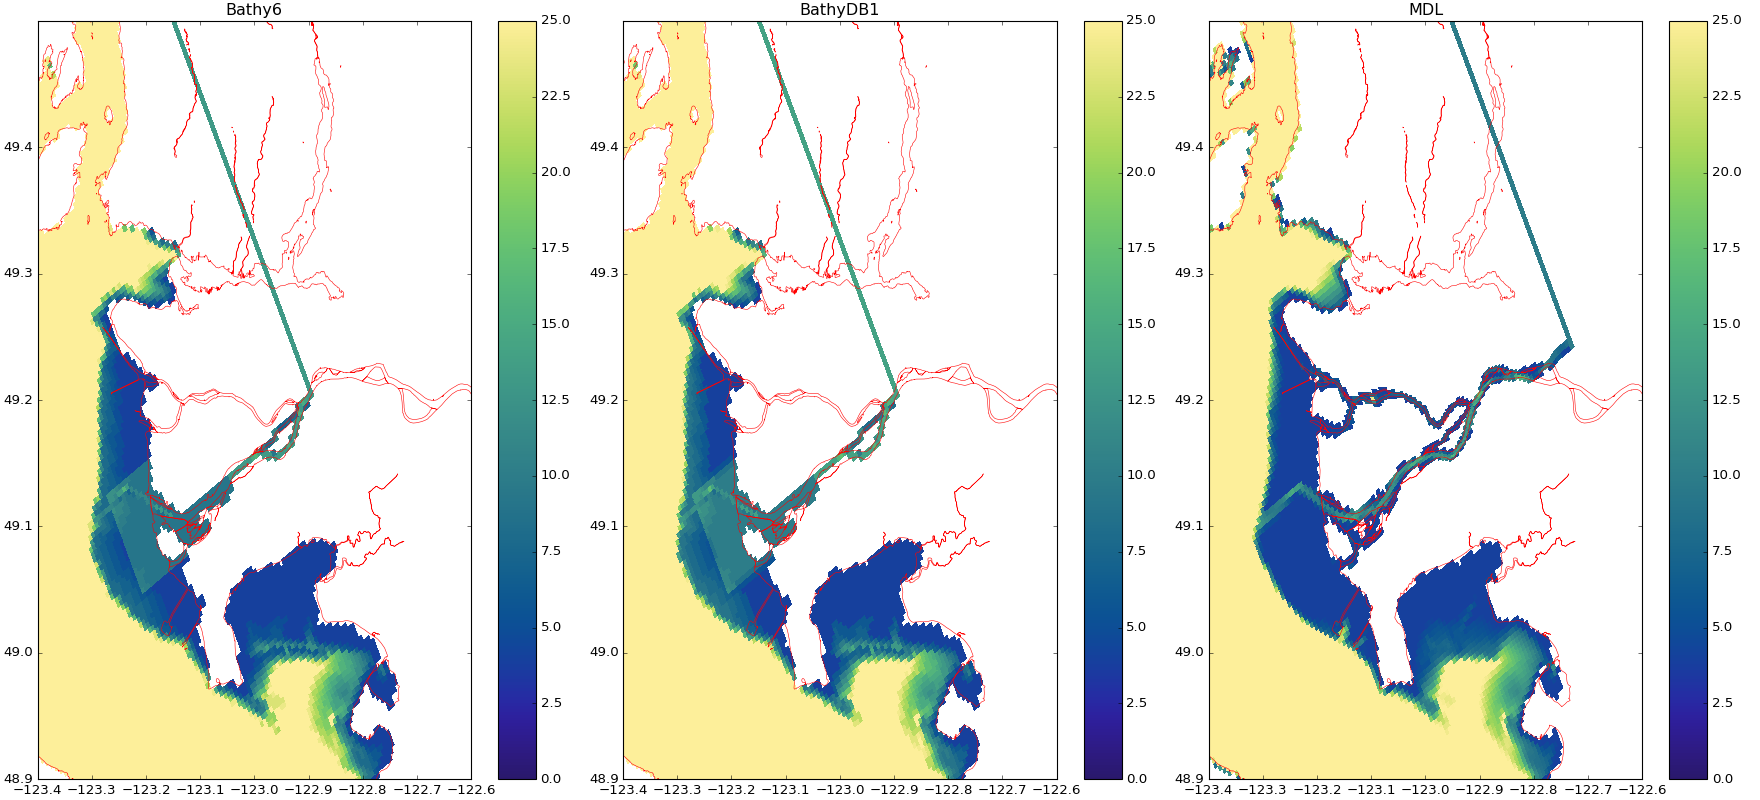

In [12]:
# Zoom in on Fraser river mouth, show new BC3 strategy
plt.figure(figsize=(22,10)); plt.clf();
cb=25
plt.subplot(1,3,1); shrz(glamf0,gphif0,glamt0,gphit0,bathy6,cb,'Bathy6')
plt.subplot(1,3,2); shrz(glamf0,gphif0,glamt0,gphit0,bathyd1,cb,'BathyDB1')
plt.subplot(1,3,3); shrz(glamf,gphif,glamf,gphif,mdL,cb,'MDL')
plt.tight_layout(pad=0.25)


<IPython.core.display.Javascript object>


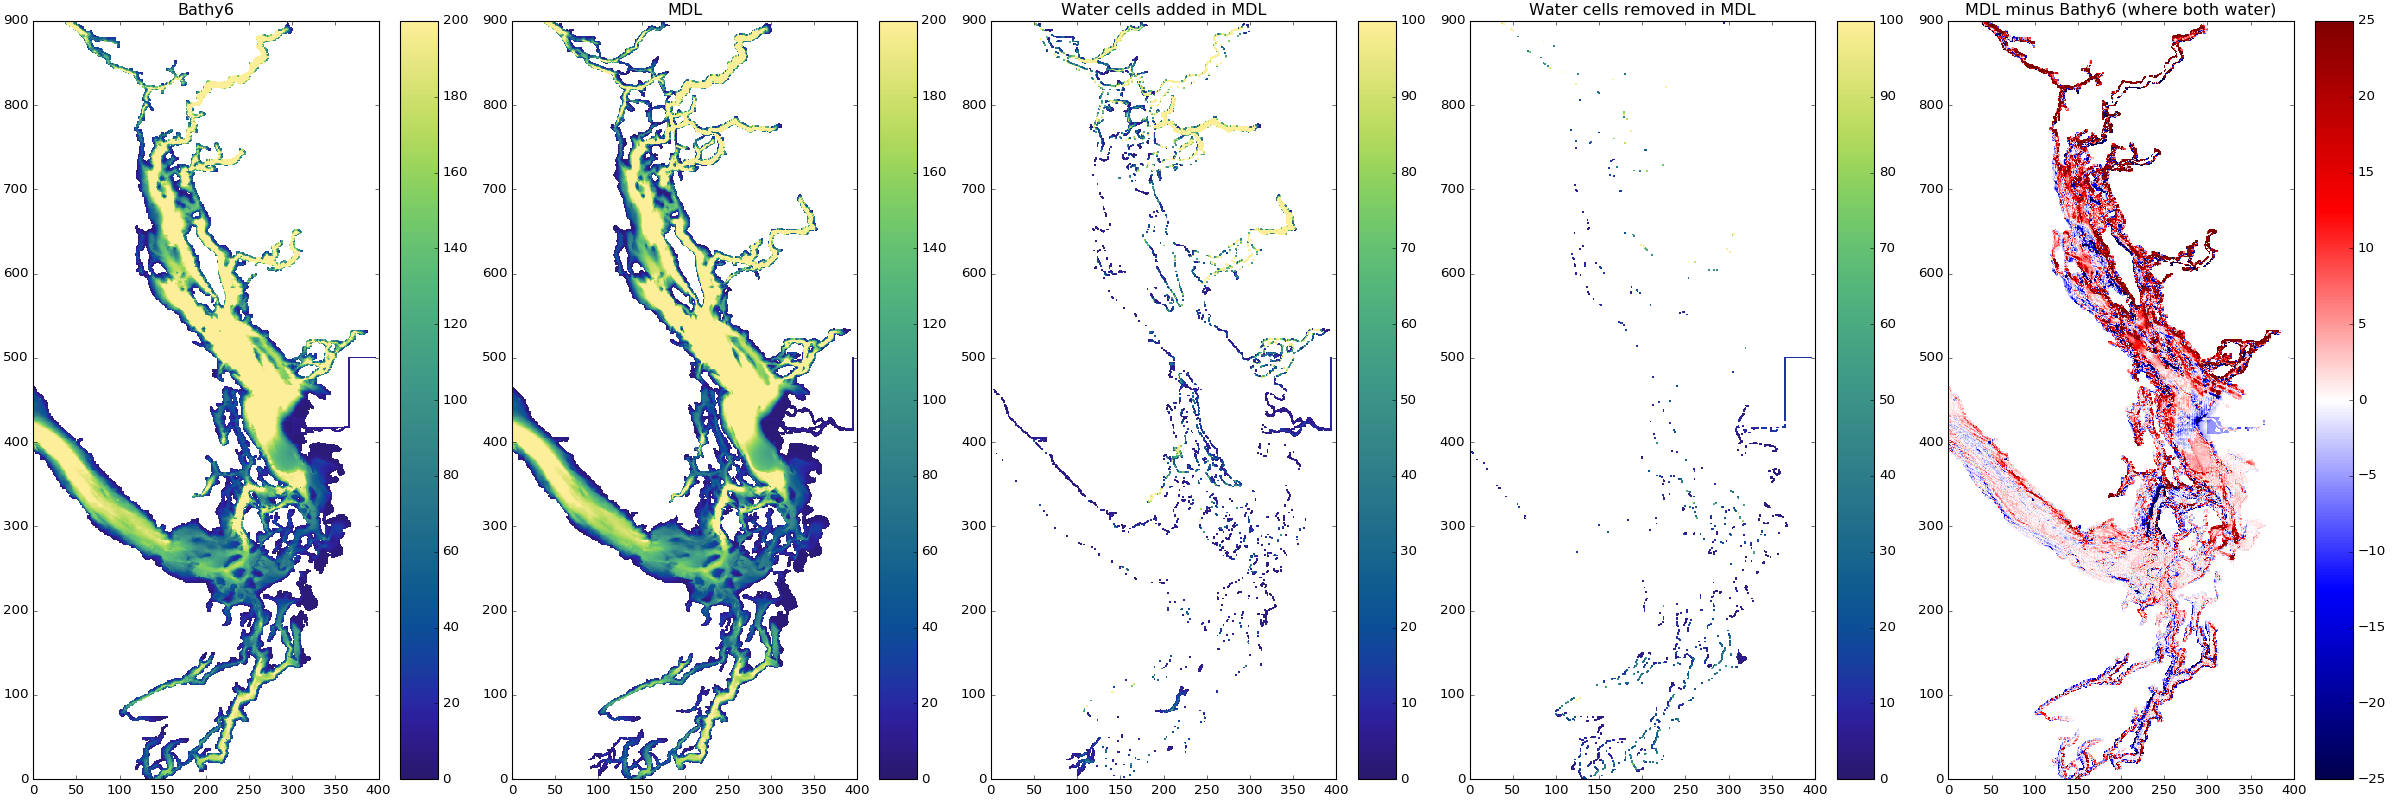

In [13]:
# Bathy6 vs MDL
plt.figure(figsize=(30,10)); plt.clf();
plt.subplot(1,5,1); shw(bathy6, None, 200, 'Bathy6')
plt.subplot(1,5,2); shw(mdL, None, 200, 'MDL')
tmp = np.copy(mdL); mask=(bathy6==0) & (mdL > 0); tmp[~mask]=0
plt.subplot(1,5,3); shw(tmp, None, 100, 'Water cells added in MDL')
tmp = np.copy(bathy6); mask=(mdL==0) & (bathy6 > 0); tmp[~mask]=0
plt.subplot(1,5,4); shw(tmp, None, 100, 'Water cells removed in MDL')

tmp = np.ones(mdL.shape); mask=(mdL>0) & (bathy6 > 0); tmp[~mask]=0
plt.subplot(1,5,5); cmp(mdL, bathy6, mm(tmp), 25, 'MDL minus Bathy6 (where both water)')

plt.tight_layout(pad=0.25)


<IPython.core.display.Javascript object>


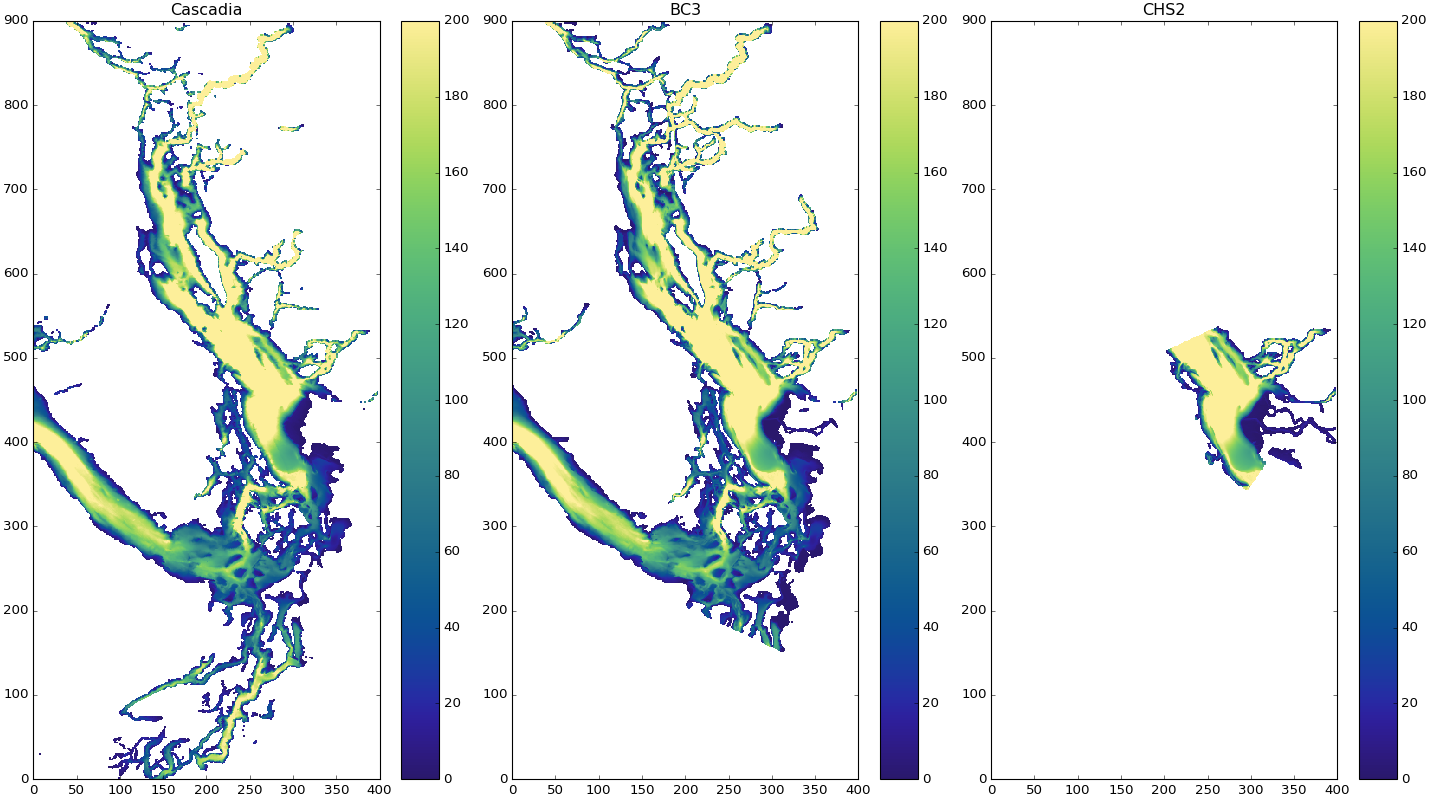

In [14]:
# Data sources
plt.figure(figsize=(18,10)); plt.clf();
plt.subplot(1,3,1); shw(casmean, None, 200, 'Cascadia')
plt.subplot(1,3,2); shw(bc3mean, None, 200, 'BC3')
plt.subplot(1,3,3); shw(chs2mean, None, 200, 'CHS2')
plt.tight_layout(pad=0.25)

In [15]:
# Write Bathymetry to NetCDF file
writebathy('/home/mdunphy/MEOPAR/WORK/Bathy-201702/bathy_meter_SalishSeaM0.nc',glamt,gphit,mdL)
